In [1]:
Полина Чижик, лабораторная работа №5

In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
X_train = torch.FloatTensor(CIFAR_train.data) 
y_train = torch.LongTensor(CIFAR_train.targets) 
X_test = torch.FloatTensor(CIFAR_test.data) 
y_test = torch.LongTensor(CIFAR_test.targets)

In [5]:
len(y_train), len(y_test)

(50000, 10000)

In [6]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [7]:
X_train /= 255.
X_test /= 255.

In [8]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

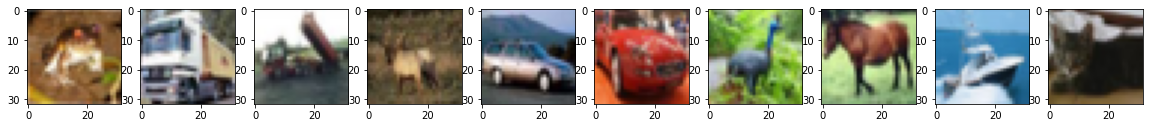

In [9]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,2)) 
for i in range(10): 
    plt.subplot(1, 10, i+1) 
    plt.imshow(X_train[i]) 
    print(y_train[i], end=' ')

In [10]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [11]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [12]:
class LeNet5(torch.nn.Module):
    def __init__(
        self,
         activation='tanh',
         pooling='avg',
         conv_size=5, 
         use_batch_norm=False
    ):
        super(LeNet5, self).__init__()
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        return x

In [13]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    batch_size = 100
    test_accuracy_history = []
    test_loss_history = []
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            preds = net.forward(X_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
            X_batch
        net.eval()
        with torch.no_grad():
             test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())
        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)
        if epoch % 5 == 0:
            print(accuracy)
    del net
    
    print('---------------')
    print(f'Max test accuracy {max(test_accuracy_history)}')
    print('---------------')
    return test_accuracy_history, test_loss_history

In [14]:
accuracies = {}
losses = {}

accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)
accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)
accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)

tensor(0.3876)
tensor(0.5182)
tensor(0.5461)
tensor(0.5588)
tensor(0.5545)
tensor(0.5472)
---------------
Max test accuracy 0.5587999820709229
---------------
tensor(0.4272)
tensor(0.5447)
tensor(0.5925)
tensor(0.6042)
tensor(0.6123)
tensor(0.6214)
---------------
Max test accuracy 0.6256999969482422
---------------
tensor(0.3669)
tensor(0.5467)
tensor(0.5841)
tensor(0.6129)
tensor(0.6227)
tensor(0.6248)
---------------
Max test accuracy 0.6288999915122986
---------------
tensor(0.4023)
tensor(0.5781)
tensor(0.6214)
tensor(0.6411)
tensor(0.6513)
tensor(0.6434)
---------------
Max test accuracy 0.6513000130653381
---------------
tensor(0.5482)
tensor(0.6520)
tensor(0.6605)
tensor(0.6447)
tensor(0.6464)
tensor(0.6353)
---------------
Max test accuracy 0.6615999937057495
---------------


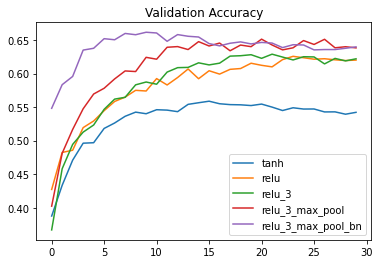

In [15]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

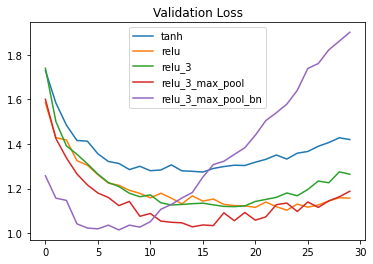

In [16]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');


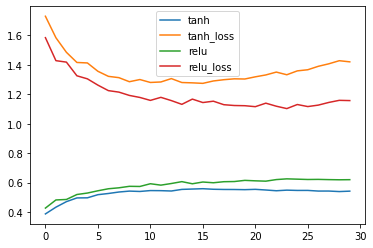

In [17]:
plt.plot(accuracies["tanh"], label="tanh")
plt.plot(losses["tanh"], label="tanh_loss")
plt.plot(accuracies["relu"], label="relu")
plt.plot(losses["relu"], label="relu_loss")
plt.legend()

Использование relu увеличило точность предсказаний на 7 процентов

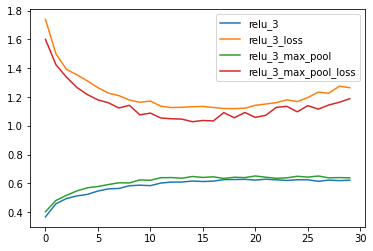

In [ ]:
plt.plot(accuracies["relu_3"], label="relu_3")
plt.plot(losses["relu_3"], label="relu_3_loss")
plt.plot(accuracies["relu_3_max_pool"], label="relu_3_max_pool")
plt.plot(losses["relu_3_max_pool"], label="relu_3_max_pool_loss")
plt.legend()

Использование max pooling  показывает улучшение результата

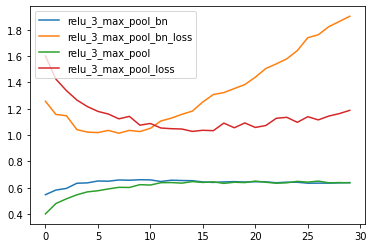

In [19]:
plt.plot(accuracies["relu_3_max_pool_bn"], label="relu_3_max_pool_bn")
plt.plot(losses["relu_3_max_pool_bn"], label="relu_3_max_pool_bn_loss")
plt.plot(accuracies["relu_3_max_pool"], label="relu_3_max_pool")
plt.plot(losses["relu_3_max_pool"], label="relu_3_max_pool_loss")
plt.legend()

Добавление батч-норм. добавило 1 процент точности